### Imports Here

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

### Read the Dataset

In [42]:
%%time
df_construction = pd.read_csv('US_Constructions_Dec21.csv')

CPU times: total: 1min 28s
Wall time: 1min 28s


### Attribute Information (Ref: https://arxiv.org/abs/2209.06813)

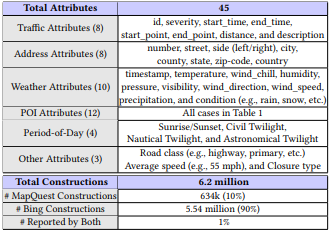

In [9]:
# -------------------------------------Memory Usage of Dataset-------------------------------------
# df_construction.info(memory_usage='deep')
df_construction.memory_usage(deep=True)

Index                          132
ID                       406171965
Severity                  49365016
Start_Time               486660038
End_Time                 486660038
Start_Lat                 49365016
Start_Lng                 49365016
End_Lat                   49365016
End_Lng                   49365016
Distance(mi)              49365016
Description              902148692
Number                    49365016
Street                   421014285
Side                     357896366
City                     405743147
County                   398347105
State                    364066993
Zipcode                  395163839
Country                  364066993
Timezone                 414078959
Airport_Code             375948336
Weather_Timestamp        465281068
Temperature(F)            49365016
Wind_Chill(F)             49365016
Humidity(%)               49365016
Pressure(in)              49365016
Visibility(mi)            49365016
Wind_Direction           363555778
Wind_Speed(mph)     

#### Observations:
1. As expected columns with dtypes as object consume highest memory followed by int/float and then bool dtypes.
2. We will reduce memory usage in the feature engineering/transformation phase.

### Memory Usage Analysis and Optimization

#### Categorical columns

In [43]:
# ?pd.select_dtypes
categorical_columns = [i for i in df_construction.select_dtypes(include='object').columns]
print(categorical_columns)


['ID', 'Start_Time', 'End_Time', 'Description', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


In [44]:
%%time
# Drop column 'ID' as it need not be converted to categorical
categorical_columns.remove('ID')
categorical_columns.remove('Start_Time')
categorical_columns.remove('End_Time')
categorical_columns.remove('Weather_Timestamp')
df_construction[categorical_columns] = df_construction[categorical_columns].astype('category')

CPU times: total: 53 s
Wall time: 53.3 s


In [45]:
%%time
# Astronomical_Twilight - 372929534(Original)  6170857(Optimized)
# 486660038  291105644
# 566120817  406171965
df_construction.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6170627 entries, 0 to 6170626
Data columns (total 47 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     object  
 1   Severity               int64   
 2   Start_Time             object  
 3   End_Time               object  
 4   Start_Lat              float64 
 5   Start_Lng              float64 
 6   End_Lat                float64 
 7   End_Lng                float64 
 8   Distance(mi)           float64 
 9   Description            category
 10  Number                 float64 
 11  Street                 category
 12  Side                   category
 13  City                   category
 14  County                 category
 15  State                  category
 16  Zipcode                category
 17  Country                category
 18  Timezone               category
 19  Airport_Code           category
 20  Weather_Timestamp      object  
 21  Temperature(F)         float64 

#### Memory optimized from 8.8 GB to 2.9 GB for our dataframe by handling categorical data

#### Datetime features - 'Start_Time', 'End_Time', 'Weather_Timestamp'
1. We have Weather_Condition as one column we may drop Weather_Timestamp

In [74]:
%%time
# to_datetime()
df_construction['Start_Time'] = pd.to_datetime(df_construction['Start_Time'])
df_construction['End_Time'] = pd.to_datetime(df_construction['End_Time'])
# Year
df_construction['start_year'] = df_construction['Start_Time'].dt.year
df_construction['end_year'] = df_construction['End_Time'].dt.year
df_construction['duration_year'] = df_construction['end_year'] - df_construction['start_year']

# Month
df_construction['start_month'] = df_construction['Start_Time'].dt.month
df_construction['end_month'] = df_construction['End_Time'].dt.month
df_construction['duration_months'] = df_construction['end_month'] - df_construction['start_month']
df_construction.loc[df_construction['duration_months']<0,'duration_months']+=12 # Account for change in year

# Hour
df_construction['start_hour'] = df_construction['Start_Time'].dt.hour
df_construction['end_hour'] = df_construction['End_Time'].dt.hour
df_construction['duration_hours'] = df_construction['end_hour'] - df_construction['start_hour']
df_construction.loc[df_construction['duration_hours']<0,'duration_hours']+=24  # Account for cahnge in day


CPU times: total: 5.98 s
Wall time: 5.66 s


#### Memory further optimized to 2.5 GB (Post handling datetime features)

In [100]:
# After converting object to datetimes and creating new features like duration of work in months,hours,year
df_construction.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6170627 entries, 0 to 6170626
Data columns (total 56 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Severity               int64         
 2   Start_Time             datetime64[ns]
 3   End_Time               datetime64[ns]
 4   Start_Lat              float64       
 5   Start_Lng              float64       
 6   End_Lat                float64       
 7   End_Lng                float64       
 8   Distance(mi)           float64       
 9   Description            category      
 10  Number                 float64       
 11  Street                 category      
 12  Side                   category      
 13  City                   category      
 14  County                 category      
 15  State                  category      
 16  Zipcode                category      
 17  Country                category      
 18  Timezone              

In [101]:
# df_construction.dtypes
df_construction[['duration_year','duration_months','duration_hours']].tail()

,duration_year,duration_months,duration_hours
6170622,1,9,15
6170623,0,0,8
6170624,0,0,5
6170625,0,0,2
6170626,0,0,6


In [85]:
# df_construction[df_construction['duration_months']<0]['Severity'].value_counts()
df_construction[df_construction['duration_months']<0]

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Astronomical_Twilight,start_year,end_year,duration_year,start_month,end_month,duration_months,start_hour,end_hour,duration_hours


In [64]:
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022)]['Severity'].value_counts()

2    2974931
4     192036
3      48017
1      11895
Name: Severity, dtype: int64

### EDA (Exploratory Data Analysis)

#### 1. Target Feature: Severity

In [10]:
# 'Severity'
df_construction['Severity'].value_counts()

2    5121363
4     598342
3     410474
1      40448
Name: Severity, dtype: int64

<Axes: xlabel='Severity', ylabel='count'>

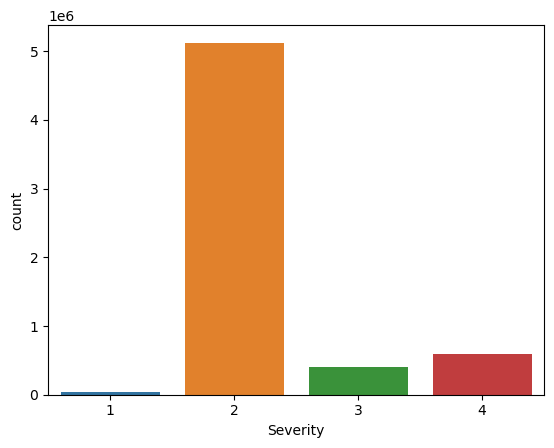

In [17]:
# Count plot to check balance in the classes
#sns.countplot(data=df_construction['Severity'],x='Severity')
sns.countplot(x=df_construction['Severity'])

#### Statewise Severity Analysis
1. Check imbalance in dataset

In [11]:
df_construction['State'].value_counts()

FL    771431
NY    574601
CA    556830
PA    490502
AZ    382709
TX    340406
IL    268764
CO    257245
OH    151801
NJ    148116
IN    147094
MI    136128
VA    134877
WA    133216
GA    130951
OR    128539
MD     94847
MN     89894
LA     89791
NC     75439
WI     74346
CT     72516
MA     68525
OK     67466
ID     64859
IA     62854
AR     61977
KS     56653
SC     50868
MO     44666
TN     43993
AL     37092
KY     35065
DE     34937
NM     34239
MT     30575
UT     26862
NV     25122
NE     25112
WY     19212
MS     18834
ME     18095
DC     17971
RI     17651
SD     17175
WV     16983
NH     12076
VT      6680
ND      5030
HI        12
Name: State, dtype: int64

In [82]:
df_construction[df_construction['State']=='PA']['Severity'].value_counts(normalize=True)*100
# NY: 2 = 87%, 4 = 6.9%, 3 = 5%, 1 = 0.4% 
# CA: 2 = 70%, 4 = 16%, 3 = 12%, 1 = 0.6% 
# FL: 2 = 92%, 4 = 4.1%, 3 = 2.4%, 1 = 0.48% 
# PA: 2 = 86%, 4 = 9.5%, 3 = 3.59%, 1 = 0.62%

2    86.248170
4     9.541245
3     3.589384
1     0.621200
Name: Severity, dtype: float64

In [88]:
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022) & (df_construction['State']=='CA')]['Severity'].value_counts()

2    159055
4     29646
3     12562
1      1752
Name: Severity, dtype: int64

In [92]:
# CA state road closures between 2021 and 2022 
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022) & (df_construction['State']=='CA')]['duration_hours'].mean()

6.550417456838165

In [93]:
# CA state road closures between 2021 and 2022 with Severity value_counts()
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022) & (df_construction['State']=='CA')]['Severity'].value_counts()

2    159055
4     29646
3     12562
1      1752
Name: Severity, dtype: int64

In [99]:
# CA state road closures between 2021 and 2022 with Severity value_counts()
df_construction[(df_construction['start_year']>=2021) & (df_construction['end_year']<=2022) & (df_construction['State']=='CA') & (df_construction['duration_months'] > 2)]['Severity'].value_counts()

2    11041
4     1945
3       24
1       22
Name: Severity, dtype: int64

In [108]:
# ?pd.DataFrame.copy
#df_copy = df_construction.copy(deep=True)

### We are proceeding with one state('CA') for this project

In [115]:
df_construction_ca = df_construction[df_construction['State']=='CA']

In [116]:
# We will work with CA data only
df_construction_ca.shape

(556830, 56)

In [118]:
df_construction_ca_recent = df_construction_ca[(df_construction_ca['start_year']>=2021) & (df_construction_ca['end_year']<=2022)]

In [119]:
df_construction_ca_recent.shape

(203015, 56)

In [120]:
df_construction_ca_recent['Severity'].value_counts()

2    159055
4     29646
3     12562
1      1752
Name: Severity, dtype: int64

### EDA Phase 2

In [122]:
df_construction_ca_recent.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203015 entries, 3 to 6170614
Data columns (total 56 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   ID                     203015 non-null  object        
 1   Severity               203015 non-null  int64         
 2   Start_Time             203015 non-null  datetime64[ns]
 3   End_Time               203015 non-null  datetime64[ns]
 4   Start_Lat              203015 non-null  float64       
 5   Start_Lng              203015 non-null  float64       
 6   End_Lat                173023 non-null  float64       
 7   End_Lng                173023 non-null  float64       
 8   Distance(mi)           203015 non-null  float64       
 9   Description            203015 non-null  category      
 10  Number                 93904 non-null   float64       
 11  Street                 203015 non-null  category      
 12  Side                   203015 non-null  cat

In [123]:
df_construction_ca_recent.isnull().sum()

ID                            0
Severity                      0
Start_Time                    0
End_Time                      0
Start_Lat                     0
Start_Lng                     0
End_Lat                   29992
End_Lng                   29992
Distance(mi)                  0
Description                   0
Number                   109111
Street                        0
Side                          0
City                         10
County                        0
State                         0
Zipcode                     137
Country                       0
Timezone                    140
Airport_Code                582
Weather_Timestamp          4135
Temperature(F)             4958
Wind_Chill(F)              6084
Humidity(%)                5194
Pressure(in)               4424
Visibility(mi)             4666
Wind_Direction             5594
Wind_Speed(mph)            5593
Precipitation(in)         17214
Weather_Condition          5105
Amenity                       0
Bump    

### 1. Analyze target feature with Description

In [132]:
# Closed Road, Full closure  severity = 4
# Road closed, entry ramp, one lane closed, intermittent lane closure  severity = 3
# stationary traffic, roadwork, construction, slow traffic  severity = 2
df_construction_ca_recent[df_construction_ca_recent['Severity']==1]['Description'].tail(10)

# So when roads are closed intermittently the severity is not high.
# Also when roads closed it could indicate severity = 3 or 2 and not 1


6137643    Road closed due to utility work on Ocean View ...
6142045    Road closed intermittently due to paving repai...
6144197    Road closed due to construction during the day...
6145504    Road closed intermittently due to resurfacing ...
6147286    Road closed due to construction work on Garden...
6153533    Road closed intermittently due to resurfacing ...
6155371    Road closed intermittently due to resurfacing ...
6156655    Road closed due to construction work on Navill...
6156773    Road closed due to bridge maintenance work on ...
6166022    Intermittent lane closures and road closed int...
Name: Description, dtype: category
Categories (1578183, object): [' 03:30 PM right lane closure', ' CONSTRUCTION AHEAD  SIGN IS CAUSING A VIS HA..., ' Meadow Street; take a right onto Freight Str..., ' SEMI W/ TL PART 1125 ON FOG LINE // BO TIRE ..., ..., 'waterville I-95 South between mile 130 to 129..., 'work is beingon done on the interstate to rep..., 'working behind barrier walls. C

In [136]:
df_construction_ca_recent[df_construction_ca_recent['Description'].str.contains('Road closed due')]['Severity'].value_counts()
# We see that for road closed due to some reason, we have few misclassified rows as 1

1    656
3    468
4    153
2     23
Name: Severity, dtype: int64

#### 2. Weather_Condition with Target feature

In [137]:
df_construction_ca_recent['Weather_Condition'].value_counts()

Fair                      123067
Cloudy                     27889
Mostly Cloudy              14244
Partly Cloudy               9313
Haze                        6840
                           ...  
Heavy Freezing Drizzle         0
Heavy Drizzle / Windy          0
Heavy Drizzle                  0
Patches of Fog / Windy         0
Light Snow Grains              0
Name: Weather_Condition, Length: 111, dtype: int64

In [147]:
# df_construction_ca_recent[df_construction_ca_recent['Weather_Condition']
df_construction_ca_recent.groupby(['Weather_Condition'])['Severity'].count()
# pd.Series.remove_unused_categories(df_construction_ca_recent['Weather_Condition'])


Weather_Condition
Blowing Dust               15
Blowing Dust / Windy       18
Blowing Sand                0
Blowing Snow                0
Blowing Snow / Windy        0
                           ..
Tornado                     0
Widespread Dust            14
Widespread Dust / Windy    16
Wintry Mix                 38
Wintry Mix / Windy          5
Name: Severity, Length: 111, dtype: int64

### Initial Feature Selection/Elimination

In [148]:
df_construction_ca_recent.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'start_year', 'end_year', 'duration_year',
       'start_month', 'end_month', 'duration_months', 'start_hour', 'end_hour',
       'duration_hours'],
      dtype='object')

In [ ]:
# We are skipping the geography based columns
features_to_drop = ['ID','Start_Time','End_Time','Start_Lat','Start_Lng','End_Lat','End_Lng','Description','Number','Street',
                    'Side','City','County','State','Zipcode','Country','Timezone',]
# Weather_Condition